In [151]:
!pip install poloniex
!pip install git+https://github.com/preslavrachev/pandas-ta.git
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import poloniex
import time
from pandasta import indicators as pdt
from pandasta.indicators import Order

/bin/sh: pip: command not found
/bin/sh: pip: command not found
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fetch the Data
For training and testing data, we will be using the [Poloniex public API](https://poloniex.com/support/api/).

In [142]:
end = int(time.time())
period = 300
start = end - 60000 * period
data = poloniex.Poloniex().returnChartData('USDT_BTC',
                                           period=period,
                                           start=start,
                                           end=end)

In [143]:
df = pd.DataFrame(data)
df['time'] = df['date']
df['close'] = df['close'].astype('float32')

# Add Indicators / Features
Using the Pandas TA conventions, we will request a few indicators, based on different tiem windows. In our current case, this will be the fast-moving part (K) of the [Stochastic Oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator) index.

In [144]:
cluster_features = ['stochk_14',
                    'stochk_30']

In [145]:
df = pdt.BacktestingTaDataFrame(df, indicators=cluster_features, funds=1000, min_amount=0.001)
df[cluster_features] = (df[cluster_features] * 100).round()
df.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,stochk_14,stochk_30
time,,,,,,,,,,
2018-08-28 05:35:00,6904.0,1535434500,6906.69999999,6904.00000011,6906.69999999,0.35863438,2476.19524381,6904.51161936,72.0,58.0
2018-08-28 05:40:00,6905.0,1535434800,6907.99999709,6901,6904,0.12103803,835.87090383,6905.85350601,70.0,60.0
2018-08-28 05:45:00,6908.0,1535435100,6907.99999882,6905,6905.00000001,0.51925218,3585.51854367,6905.1583831,70.0,60.0
2018-08-28 05:50:00,6910.0,1535435400,6910,6904.09984155,6908.54307989,4.56309809,31525.22731567,6908.73321017,70.0,60.0
2018-08-28 05:55:00,6904.0,1535435700,6905,6903.99984675,6905,0.3164425,2184.77654387,6904.18178303,67.0,64.0


# Add a basic strategy
The strategy will use the following assumption:
- Every time the `stochk_14` indicator goes below 20, buy a certain amount
- Every time the `stochk_14` indicator goes above 80, sell a certain amount

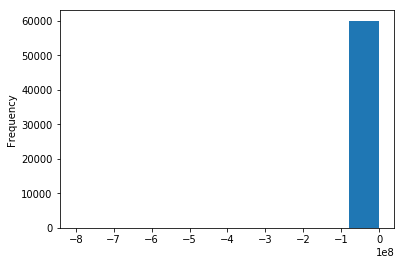

In [146]:
df[df['stochk_14'] <= 100]['stochk_14'].plot.hist()

In [147]:
class StochKStrategy(pdt.TradingStrategy):
    def generate_order(self, record, funds, balance) -> pdt.Order:
        amount = 0.001
        if record['stochk_14'] <= 15:
            return Order(decision=pdt.Order.Decision.BUY, amount=funds/record['close']*0.05)
        elif record['stochk_14'] >= 90:
            return Order(decision=pdt.Order.Decision.SELL, amount=balance*0.04)
        #print("reached this point: ", record['stochk_14'])
        return

In [148]:
res = df.apply_strategy(strategy = StochKStrategy())

In [149]:
#res.describe()
res[res['amounts'] > 0].tail()

,amounts,balance,buy_hold,decisions,funds,statuses,worth
time,,,,,,,
2018-08-26 10:10:00,0.003670,0.088072,659.408875,SELL,187.553549,FILLED,774.904254
2018-08-26 11:35:00,0.003523,0.084549,663.450852,SELL,211.191588,FILLED,778.504536
2018-08-26 13:50:00,0.003382,0.081167,663.092665,SELL,233.871855,FILLED,778.198253
2018-08-26 13:55:00,0.003247,0.077920,665.237974,SELL,255.715353,FILLED,779.959316
2018-08-26 14:00:00,0.003117,0.074804,665.638116,SELL,276.697725,FILLED,780.274650


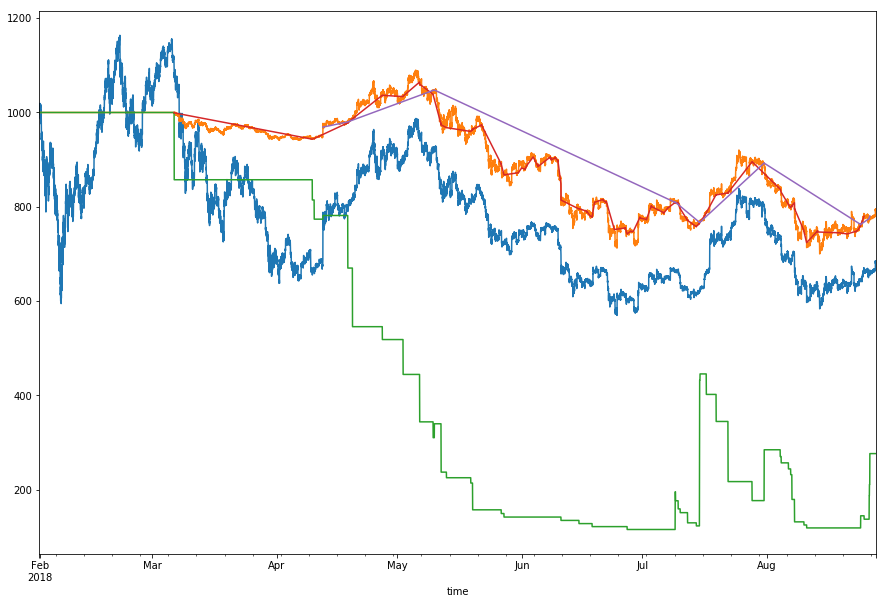

In [150]:
res['buy_hold'].plot.line(figsize=(15, 10))
res['worth'].plot.line()
res['funds'].plot.line()
res[res['decisions'] == 'BUY']['worth'].plot.line()
res[res['decisions'] == 'SELL']['worth'].plot.line()